In [ ]:
import scipy
import scipy.sparse as sparse
import scipy.sparse.linalg as spalin
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt


def gen_s0sxsysz(L):
    sx = sparse.csr_matrix([[0., 1.],[1., 0.]])
    sy = sparse.csr_matrix([[0.,-1j],[1j,0.]])
    sz = sparse.csr_matrix([[1., 0],[0, -1.]])
    s0_list =[]
    sx_list = []
    sy_list = []
    sz_list = []
    I = sparse.eye(2**L, format='csr', dtype='complex')
    for i_site in range(L):
        if i_site==0:
            X=sx
            Y=sy
            Z=sz
        else:
            X= sparse.csr_matrix(np.eye(2))
            Y= sparse.csr_matrix(np.eye(2))
            Z= sparse.csr_matrix(np.eye(2))

        for j_site in range(1,L):
            if j_site==i_site:
                X=sparse.kron(X,sx, 'csr')
                Y=sparse.kron(Y,sy, 'csr')
                Z=sparse.kron(Z,sz, 'csr')
            else:
                X=sparse.kron(X,np.eye(2),'csr')
                Y=sparse.kron(Y,np.eye(2),'csr')
                Z=sparse.kron(Z,np.eye(2),'csr')
        sx_list.append(X)
        sy_list.append(Y)
        sz_list.append(Z)
        s0_list.append(I)

    return s0_list, sx_list,sy_list,sz_list


def gen_op_total(op_list):
    L = len(op_list)
    tot = op_list[0]
    for i in range(1,L):
        tot = tot + op_list[i]
    return tot

def gen_op_prod(op_list):
    L= len(op_list)
    P = op_list[0]
    for i in range(1, L):
        P = P*op_list[i]
    return P

def gen_interaction_kdist(op_list, op_list2=[],k=1, bc='obc'):
    L= len(op_list)

    if op_list2 ==[]:
        op_list2=op_list
    H = sparse.csr_matrix(op_list[0].shape)
    Lmax = L if bc == 'pbc' else L-k
    for i in range(Lmax):
        H = H+ op_list[i]*op_list2[np.mod(i+k,L)]
    return H

## Question 1: Anderson Localization (20pts)##

A simple model of Anderson localization in one dimension is
$ H = \sum_r t(c^\dagger_r c_{r+1} + c^\dagger_{r+1} c_{r}) +h_r c^\dagger_rc_r$, where $t$ is a nearest neighbor hopping, and $h_r$ are random onsite potentials drawn independently and randomly from a uniform distribution of width $W$:  $h_r \in [-W, W]$. As usual, $c_r, c_r^\dagger$ are annihilation/creation operators for fermions on site $r$, and $c^\dagger_rc_r$ is number of fermions on site $r$.

Note that this is a "free" or "non-interacting" or "single-particle" model. There is only one particle which can hop on a chain (the hopping is a discretized lattice version of the kinetic energy term in a Hamiltonian), and  $v_r$ represents the potential energy landscape the particle is hopping in. Later we will consider many-body Hamiltonians in which there are many fermions in a disordered landscape and they are interacting with each other.

This model is localized for infinitesimal $W$. This means that the single-particle eigenfunctions $ |\psi_n(r)|^2 \sim e^{-(r-r_n)/\xi}$ are exponentially localized in space, with a localization length $\xi$ set by the disorder strength $W/t$.



(a) Write a function `gen_Anderson(L, W,t)` which returns an $LxL$ matrix representating the Hamiltonian. Note that this Hamiltonian is only $L$ dimensional rather than $2^L$ dimensional because this is a single-particle problem. You should work in the particle occupation basis where basis state $|i\rangle$ represents the fermion on site $i$. In this basis, the potentials live on the diagonal, $H[r,r]=h_r$, while the hopping terms represent off-diagonal entries, $H[r,r+1]=H[r-1,r]= t$. You can work with open boundary conditions. You might find the function np.random.uniform useful. (5 pts)

In [ ]:
#On site potentials are on the diagonal, hopping between adjacent sites are on the adjacent diagonals.
import scipy.linalg as la

def gen_Anderson(L, W,t):
  #fill in hopping terms in hamiltonian
  H = la.toeplitz(t * (np.arange(L) == 1))
  #Fill in random diagonals
  H = H + np.diag(np.random.uniform(low=-W, high=W, size=L))
  return H
gen_Anderson(3, 1, 1)

array([[-0.72576343,  1.        ,  0.        ],
       [ 1.        ,  0.80254527,  1.        ],
       [ 0.        ,  1.        ,  0.28610834]])


(b) Pick $L=1000, t=1$, and vary $W = [0.25, .35, .5, 1, 2.5, 5]$.  Diagonalize the Hamiltonian for each $W$ for a single disorder realization, and plot the middle 10 eigenstates on a single plot, with a different plot for each $W$. Do you see the wavefunctions getting more delocalized as you lower $W$? Note that the wavefunctions are localized for any $W$. However, as you lower $W$, the localization length may become larger than the system size, so the wavefunctions may look delocalized until you consider even larger sizes. As an example, plot the wavefunctions for $W=0.35$ for both $L=1000$ and $L=4000$ to see this. (7 pts)


> We do see the wavefunctions getting more delocalized as we lower $W$.

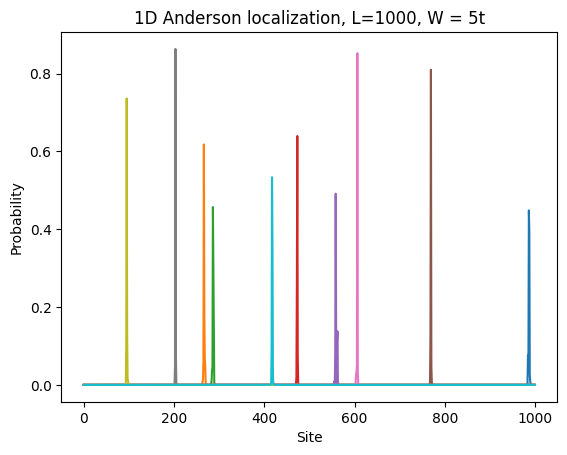

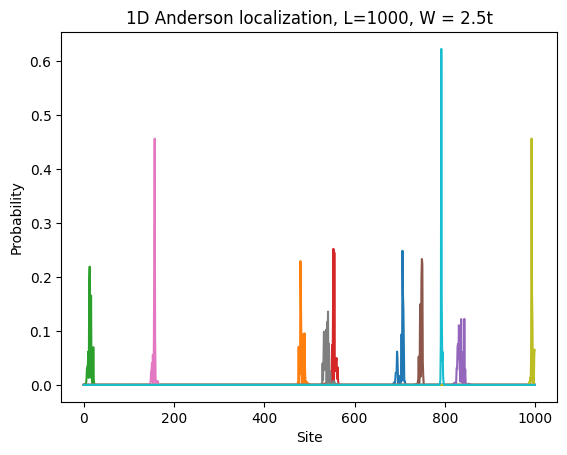

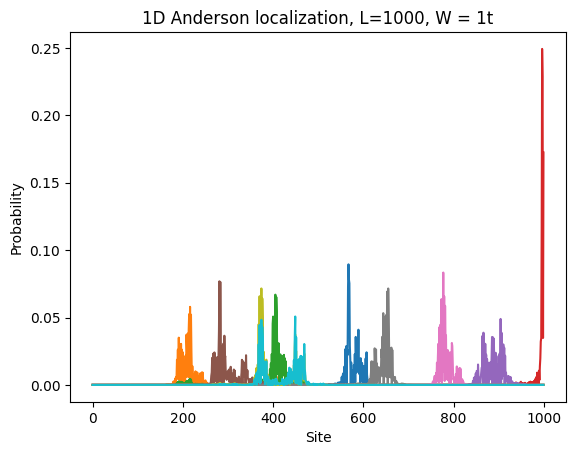

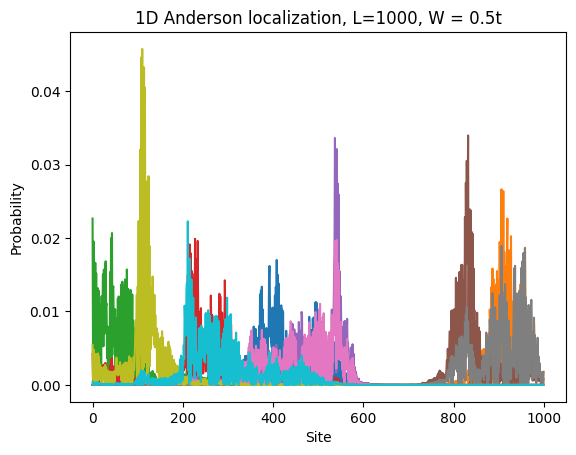

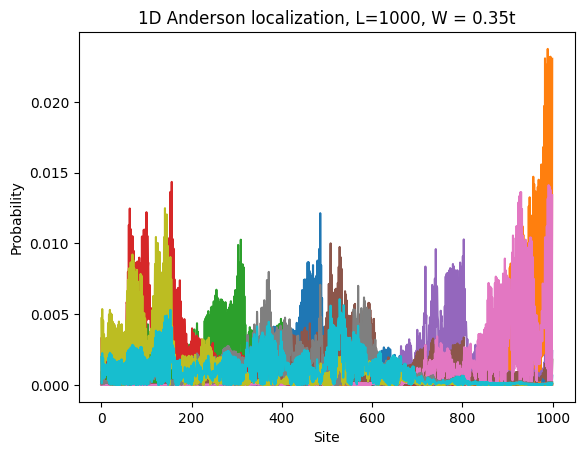

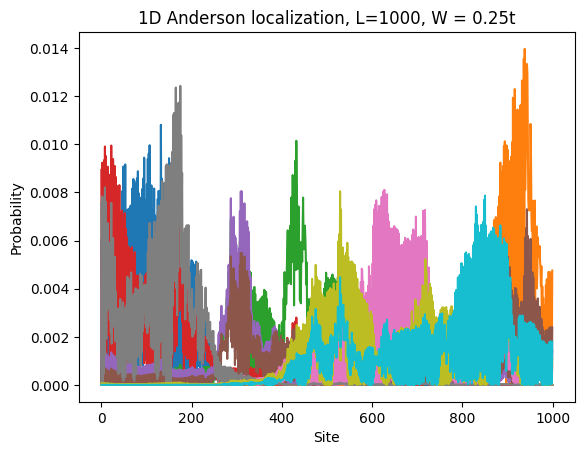

In [ ]:
L = 1000
W = [0.25, .35, .5, 1, 2.5, 5]
t = 1

def plot_wavefunctions(L, W, t):
  H = gen_Anderson(L, W, t)
  evals, evecs = la.eigh(H)
  middle10 = evecs[:, L//2 - 5:L//2 + 5]
  for i in range(middle10.shape[1]):
    plt.plot(np.abs(middle10[:, i])**2)
    plt.title(f"1D Anderson localization, L={L}, W = {W}t")
    plt.xlabel("Site")
    plt.ylabel("Probability")
  plt.show()

for w in reversed(W):
  plot_wavefunctions(L, w, t)



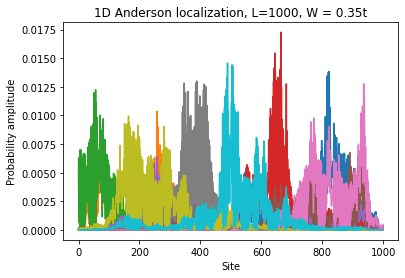

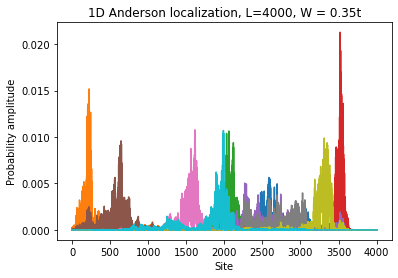

In [ ]:
plot_wavefunctions(1000, 0.35, 1)
plot_wavefunctions(4000, 0.35, 1)



(c) A simple measure of the localization length of a wavefunction is the participation ratio, $PR(\psi) = \sum_r |\psi(r)|^2/\sum_r |\psi(r)|^4$. Note that the numerator is one when the wavefunction is normalized. For a completely delocalized wavefunction in which $\psi_{\rm deloc}(r)\sim 1/\sqrt{L}\; \forall \; r$, $PR(\psi_{\rm deloc}) = L$. For a completely localized wavefunction, $\psi_{\rm loc}(r) = 1$ for $r=r_0$, $PR(\psi_{\rm loc}) = 1$. Vary $W$ in the range $[0.1, 5]$ and plot $PR(W)$ averaged over the middle third of eigenstates for $L=1000$. If the curve does not look smooth, you can average over a few independent disorder realizations (this means you should generate different Hamiltonians with fields drawn randomly, obtain the eigenstate averaged PR for each Hamiltonian, and then average over the different disorder realizations). (8pts)








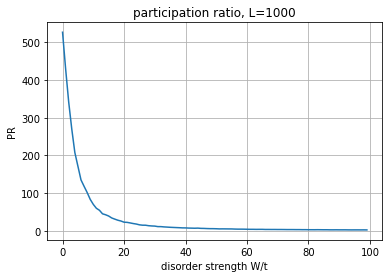

In [ ]:
def PR(L, Ws, t):
  PRs = []
  #Average over 5 disorder realizations
  for i in range(5):
    PRsample = []
    #Calculate PR(psi) for each w in Ws
    for w in Ws:
      H = gen_Anderson(L, w, t)
      evals, evecs = la.eigh(H)
      middle = evecs[:, L//3:2*L//3]
      pr =  np.mean(1 / np.sum(np.power(middle, 4), axis=0))
      PRsample.append(pr)
    PRs.append(PRsample)
  avgPRs = np.mean(PRs, axis=0)
  plt.plot(avgPRs)
  plt.title(f"participation ratio, L={L}")
  plt.xlabel("disorder strength W/t")
  plt.ylabel("PR")
  plt.grid()
  #return pr

PR(1000, np.linspace(0.1, 5, 100), 1)

## Question 2: Entanglement entropy (15pts) ##

(a) Write a function `EntanglementEntropy(psi, x)` which takes a **many-body** wavefunction of spin 1/2 qubits (so the wavefunction will have size $2^L$). The function should return the von Neumann entanglement entropy $S$ between a subsystem $A \in [0, \rm x]$ on the leftmost $\rm cxut$ sites, and subsystem $B \in [x+1, L-1]$ on the remaining sites. You might find it helpful to read Section 4.1.1 in https://arxiv.org/pdf/1008.3477.pdf. Computing $S$ is as simple as reshaping the state to compute the matrix $\Psi_{ij}$ in Equation (20) of the reference above, and then performing an SVD on this matrix to obtain the singular values, which may then be used to compute $S$ via Equation (25). (10 pts)

In [ ]:
def EntanglementEntropy(psi, x):
    #Reshape ket into square matrix to get psi operator
    psihat = psi.reshape(2**x, int(2**(np.log2(len(psi)) - x)))
    #Compute SVD of psihat to get the (square root) of the eigenvalues of the partial density operator.
    #These eigenvalues are precisely the Schmidt coefficients.
    d = np.linalg.svd(psihat, compute_uv=False)
    #Compute Von Neumann entropy using Schmidt coefficients.
    return -sum((d**2) * np.log2((d**2), ))



(b) Generate a random Gaussian state of size $2^L$ and $L=10$. You can do this by independently picking the entries from random normal distributions, and then normalizing the state. This is a chaotic eigenstate which is expected to show volume law scaling for the entanglement entropy. For this state, plot $S(x)$ vs. $x$ for $x\in [0, L-1]$. Does it behave as expected? (5 pts)

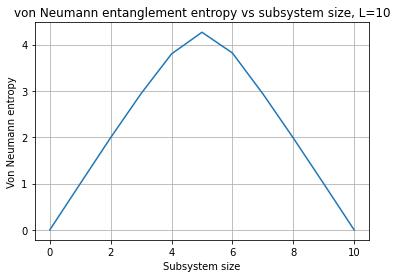

In [ ]:
def gen_gaussian_state(L):
  vec = np.random.normal(size=2**L)
  return vec / np.linalg.norm(vec)

chaotic_state = gen_gaussian_state(10)
entropies = []
for x in range(11):
  entropies.append(EntanglementEntropy(chaotic_state, x))
plt.plot(entropies)
plt.title(f"von Neumann entanglement entropy vs subsystem size, L=10")
plt.xlabel("Subsystem size")
plt.ylabel("Von Neumann entropy")
plt.grid()

We do indeed see volume law scaling with subsystem size; entropy is linear in system size as we expect (extensive entropy for chaotic states). Note that the entanglement entropy is symmetric about subsystem size = L/2 because the entanglement entropy of subsystem A and subsystem B must be equal, so we expect, for example, the entropy of a length 2 subsystem to equal the entropy of a length 8 subsystem.

## Question 3: Many-Body Localization (90 pts)##

There are several eigenspectrum diagnostics that can distinguish between MBL and thermalizing phases, and probe the transition between these phases. Note that all of these diagnostics are highly non-standard from the point of view of many-body theory. They are probing dynamical properties for highly excited eigenstates, as opposed to thermodynamical properties at low temperatures. Further, the MBL transiton proceeds via a singular rearrangement of the *quantum entanglement* properties of excited MB eigenstates, and hence entanglement-based measures have proved quite informative in understanding this novel transition.

We will study these in a one-dimensional `standard model' for the MBL transition introduced by Pal and Huse in 2010 (https://arxiv.org/abs/1010.1992):

$H =  \sum_i J(S_i^x S_{i+1}^x + S_i^y S_{i+1}^y) + J_z S_i^z S_{i+1}^z + h_i S_i^z $

where $S_i^\alpha = \frac{1}{2} \sigma_i^\alpha$ are spin 1/2 operators, the fields $h_i\in [-W, W] $ are drawn from a uniform distribution of width $W$, and $J= J_z =1$.

Under a Jordan-Wigner transformation, the up/down states in the $\sigma_i ^z$ basis correspond to occupied/empty fermion states on site $i$, the term $J(S_i^x S_{i+1}^x + S_i^y S_{i+1}^y)$ maps to nearest neighbor hopping of fermions, the term $J_z S_i^z S_{i+1}^z$ maps to a nearest-neighbor density-density interaction between fermions, and $h_i S_i^z $ is a disordered onsite potential energy. When $J_z=0$, this is the model of non-interacting Anderson electrons you studied in Question 1, which is localized for arbitrarily small $W/J$. In the presence of interactions, this model shows a finite-size crossover at a value of $W_c/J\approx 3$ (the asymptotic $W_c$ is likely much larger, but we won't worry about this for now).

This model has a $U(1)$ symmetry $[H, S^z_{\rm tot}]=0$, and we will always **work within the $S^z_{\rm tot} =0$ sector** below. Further, we will **consider only the middle third of eigenstates** in this sector to probe infinite temperature properties (i.e. energy densities corresponding to infinite temperature). Further, the various diagnostics we will use will have to be **averaged over several different random `realizations' of the disorder** to get good statistics and understand the representative behavior at a given value of $W$. The number of disorder realizations you have to average over can vary from 100s-1000s in order to get smooth data, depending on the system size.

Note: the most computationally expensive step of all the calculations below is matrix diagonalization. In disordered problems, you will have to do many diagonalizations (several values of $W$, $L$, and several independent realizations for each $W$). It is strongly recommended to only do the diagonalizations once, and to compute all the properties listed below once you have the eigenvalues and eigenvectors instead of redoing the diagnolizations for each questoon. You may also consider saving the processed data in your Google Drive ($r$, $S$, etc.) for future use.

The diagnostics we will study are:

(a) [15 pts] The presence or absence of **level repulsion in the eigenspectrum**. The MBL phase displays a form of emergent integrability and hence shows Poissonian level statistics, which thermalizing phases show GOE/GUE level statistics. We had previously studied the *distributions* of the r-ratio as a probe of level repulsion. It is sometimes more convenient to study just the average value of $\langle r \rangle$ (averaged over the desired energy window from the spectrum and/or disorder). From the analytic forms of the distributions, one can show that $\langle r \rangle_{\rm Poisson} \approx 0.38$ and $\langle r \rangle_{\rm GOE} \approx 0.54$. On a single plot, plot $\langle r\rangle$ against $W$ for $L=8,10,12$, varying $W$ in the range $W\in [0.5, 10]$. You should find "step-function" like curves that interpolate from .54 for small $W$ to .38 for larger $W$. The curves becomes steeper with increasing $L$, and the ``crossing" for these curves serves as an estimate of the transition. (See figure 3 in Pal and Huse).

> For the following parts, I average over 100 disorder realizations for each statistic (it took about 12 minutes to generate spectra for 100 realizations and 12 value of W -> 1200 diagonalizations for each of L=8,10, and 12).

In [ ]:
#Generate projector onto total spin zero sector (code taken from pset 3 solution)
def P_totalZ(L, sector = 0): # Enter the total Z spin desired
  basis = []
  for i in range(2**L):
    Nd = sum(int(digit) for digit in bin(i)[2:])
    if L - 2*Nd == sector:
      basis.append(i)
  P = sparse.eye(2**L, format='csr')[basis].T
  return P


# Heisenberg spin-1/2 chain with random fields along the z-direction, spin zero sector
def MBL(L, W, J=1):
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)
  hs = np.random.uniform(low=-W, high=W, size=L)
  H = sparse.csr_matrix((2**L, 2**L))
  for i in range(L):
    H += (J/4) * (sz_list[i] @ sz_list[(i+1)%L] + sy_list[i] @ sy_list[(i+1)%L]
                  + sx_list[i] @ sx_list[(i+1)%L] ) + 0.5*hs[i] * sz_list[i]
  #Isolate total spin zero sector of full Hamiltonian
  P = P_totalZ(L)
  H = P.T @ H @ P
  return H

#Compute the middle third of the spectrum using sparse methods
def diagonalizeH(L, W):
  H = MBL(L, W).toarray()
  #return middle third of spectrum
  evals, evecs = la.eigh(H)
  l = len(evals)//3
  return evals[l:2*l], evecs[:,l:2*l]

#Compute average level repulsion
def avg_r(levels):
  rs = []
  diffs = np.abs(np.diff(levels))
  for i in range(len(diffs)-1):
    r = min(diffs[i], diffs[i+1])/max(diffs[i], diffs[i+1])
    rs.append(r)
  return np.mean(rs)


We generate spectra for L=8,10,12 over 10 W values from 0.5 to 10 and save the data.

In [ ]:
L8spectra = []
L10spectra = []
L12spectra = []
#Generate 100 realizations and compute spectra over L=8,10,12 for 12 W values in [0.5,10]
Ws = np.linspace(0.5, 10, 12)
for i in range(100):
  L8sample = []
  L10sample = []
  L12sample = []
  for w in Ws:
    L8sample.append([w, diagonalizeH(8, w)])
    L10sample.append([w, diagonalizeH(10, w)])
    L12sample.append([w, diagonalizeH(12, w)])
  L8spectra.append(L8sample)
  L10spectra.append(L10sample)
  L12spectra.append(L12sample)


In [ ]:
L8spectra[0][0][1][0]

array([-0.80922001, -0.76367247, -0.6988924 , -0.64523305, -0.61921699,
       -0.53609068, -0.48040903, -0.45236211, -0.41985465, -0.29389013,
       -0.26935258, -0.26270748, -0.2236006 , -0.15140932, -0.03840636,
       -0.03049099, -0.00140971,  0.08313187,  0.09369314,  0.12302635,
        0.1971602 ,  0.29418583,  0.34000177])

In [ ]:
import pickle
with open('L8spectra.pkl', 'wb') as f:
  pickle.dump(L8spectra, f)
with open('L10spectra.pkl', 'wb') as f:
  pickle.dump(L10spectra, f)
with open('L12spectra.pkl', 'wb') as f:
  pickle.dump(L12spectra, f)

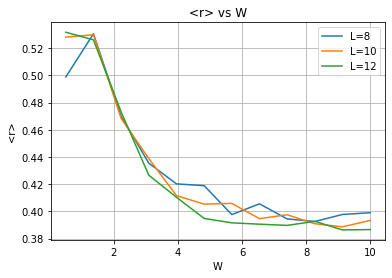

In [ ]:
Ls = [8, 10, 12]
avgs8 = []
avgs10 = []
avgs12 = []
for w_index in range(len(Ws)):
  #average over disorder realizations
  sample8 = []
  sample10 = []
  sample12 = []
  for i in range(100):
    sample12.append(avg_r(L12spectra[i][w_index][1][0]))
    sample10.append(avg_r(L10spectra[i][w_index][1][0]))
    sample8.append(avg_r(L8spectra[i][w_index][1][0]))
  avgs8.append(np.mean(sample8))
  avgs10.append(np.mean(sample10))
  avgs12.append(np.mean(sample12))

plt.plot(Ws, avgs8, label='L=8')
plt.plot(Ws, avgs10, label='L=10')
plt.plot(Ws, avgs12, label='L=12')
plt.legend()
#plt.xscale('log')
plt.xlabel('W')
plt.ylabel('<r>')
plt.title('<r> vs W')
plt.grid()

In [ ]:
avg_r(diagonalizeH(8, 1)[0])

1.0043613537273322


(b) [15 pts] The **scaling of entanglement entropy $S$** of highly-excited eigenstates obeys a volume law (with the thermal co-effiecient) in a thermalizing phase, while is obeys an area law in the MBL phase. Make a plot of $\langle S\rangle$ against $W$ for $L=8,10,12$. Do you see the area and volume law phases for large and small $W$? For specificity, consider the mid-cut von Neumann entanglement entropy (dividing the system into two equal halves), and average $S$ over the central eigenstates and disorder realizations. Note: your entanglement entropy function assumes that your state has a dimension $2^L$, while your projected diagonalization returns a state of dimension $L \choose {L/2}$. Use $P.T$ to convert the eigenstate back to the full basis before calculating $S$.

C:\Users\kapil\AppData\Local\Temp\ipykernel_7772\3616388125.py:8: RuntimeWarning: divide by zero encountered in log2
  return -sum((d**2) * np.log2((d**2), ))
C:\Users\kapil\AppData\Local\Temp\ipykernel_7772\3616388125.py:8: RuntimeWarning: invalid value encountered in multiply
  return -sum((d**2) * np.log2((d**2), ))


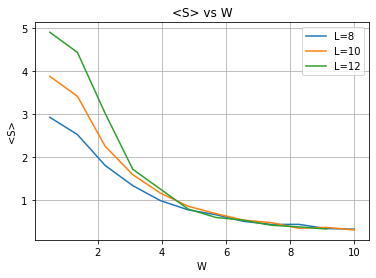

In [ ]:
avgS8 = []
avgS10 = []
avgS12 = []
for w_index in range(len(Ws)):
  S8 = []
  S10 = []
  S12 = []
  for i in range(100):
    evecs8 = L8spectra[i][w_index][1][1]
    evecs10 = L10spectra[i][w_index][1][1]
    evecs12 = L12spectra[i][w_index][1][1]
    full_evec8 = P_totalZ(8).toarray() @ evecs8
    full_evec10 = P_totalZ(10).toarray() @ evecs10
    full_evec12 = P_totalZ(12).toarray() @ evecs12
    for i in range(evecs8.shape[1]): S8.append(EntanglementEntropy(full_evec8[:,i], 8//2))
    for i in range(evecs10.shape[1]): S10.append(EntanglementEntropy(full_evec10[:,i], 10//2))
    for i in range(evecs12.shape[1]): S12.append(EntanglementEntropy(full_evec12[:,i], 12//2))
  avgS8.append(np.mean(S8))
  avgS10.append(np.mean(S10))
  avgS12.append(np.mean(S12))

plt.plot(Ws, avgS8, label='L=8')
plt.plot(Ws, avgS10, label='L=10')
plt.plot(Ws, avgS12, label='L=12')
plt.legend()
#plt.xscale('log')
plt.xlabel('W')
plt.ylabel('<S>')
plt.title('<S> vs W')
plt.grid()

> We expect volume law entanglement for small $W$ (chaotic eigenstates). This means that our average entanglement entropy $\langle S \rangle$ should scale linearly with system size $L$. We do indeed see this for small $W$ where our $\langle S \rangle$ values are evenly spaced between L=8,10,12. At the MBL transition at around $W=3$ we see that the entropies for different system sizes converge to one value - this reflects area law entanglement. In a 1D system, area law entanglement is just O(1) since the boundaries are just points, and we see this. We also see entanglement entropy decreasing as our fermions become more localized, as we expect.



(c) [15 pts] Because the entanglement entropy changes from an area law to a volume law, a diagnostic of the transition is furnished by studying the **standard deviation of the entanglement entropy** as a function of $W$, $\sigma_S$, which peaks at $W_c$, with a peak height that increases with $L$ (this variance can either (i) be computed over eigenstates in the middle of the spectrum, and then averaged over disorder realizations or (ii) computed across eigenstates and disorder realizations). Make a plot of $\sigma_S$ against $W$ for $L=8,10,12$.


C:\Users\kapil\AppData\Local\Temp\ipykernel_7772\3616388125.py:8: RuntimeWarning: divide by zero encountered in log2
  return -sum((d**2) * np.log2((d**2), ))
C:\Users\kapil\AppData\Local\Temp\ipykernel_7772\3616388125.py:8: RuntimeWarning: invalid value encountered in multiply
  return -sum((d**2) * np.log2((d**2), ))


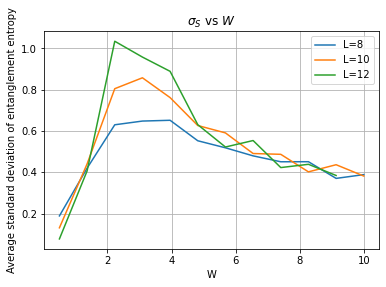

In [ ]:
avgSD8 = []
avgSD10 = []
avgSD12 = []
for w_index in range(len(Ws)):
  SD8 = []
  SD10 = []
  SD12 = []
  for i in range(100):
    evecs8 = L8spectra[i][w_index][1][1]
    evecs10 = L10spectra[i][w_index][1][1]
    evecs12 = L12spectra[i][w_index][1][1]
    full_evec8 = P_totalZ(8).toarray() @ evecs8
    full_evec10 = P_totalZ(10).toarray() @ evecs10
    full_evec12 = P_totalZ(12).toarray() @ evecs12
    for i in range(evecs8.shape[1]): SD8.append(EntanglementEntropy(full_evec8[:,i], 8//2))
    for i in range(evecs10.shape[1]): SD10.append(EntanglementEntropy(full_evec10[:,i], 10//2))
    for i in range(evecs12.shape[1]): SD12.append(EntanglementEntropy(full_evec12[:,i], 12//2))
  avgSD8.append(np.std(SD8))
  avgSD10.append(np.std(SD10))
  avgSD12.append(np.std(SD12))

plt.plot(Ws, avgSD8, label='L=8')
plt.plot(Ws, avgSD10, label='L=10')
plt.plot(Ws, avgSD12, label='L=12')
plt.legend()
#plt.xscale('log')
plt.xlabel('W')
plt.ylabel('Average standard deviation of entanglement entropy')
plt.title('$\sigma_S$ vs $W$')
plt.grid()

In [ ]:
avgSD8

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


(d) [15pts] **MBL systems do not obey the ETH**. The eigenstates are product states of emergent local integrals of motion, $\tau_i^z$ (which are weakly dressed versions of $\sigma_i^z$), and the expectation values of $\tau_i^z$ wildly fluctuate from one eigenstate to the next in the MBL phase. In contrast, local observables are a smooth function of energy density in the thermalizing phase.

* Choosing a single disorder realization at each $W$, make scatter plots of $\langle \alpha |\sigma_{L/2}^z|\alpha \rangle$ vs $E_\alpha$ for eigenstates $|\alpha\rangle$ and $L=10, 12$. Plot the different sizes on a single figure, but make a different figure for each $W$. What do you observe?
*   Choose a single disorder realization at each $W$ at $L=12$, and obtain all the  $\langle \alpha |\sigma_{L/2}^z|\alpha \rangle$ values for the middle third of eigenstates. Scatter plot all of these along the $y$ axis with $W$ as the $x$ axis.  What do you observe?



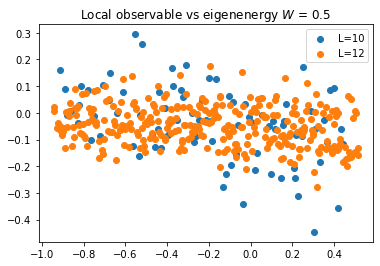

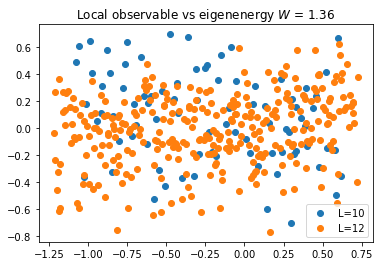

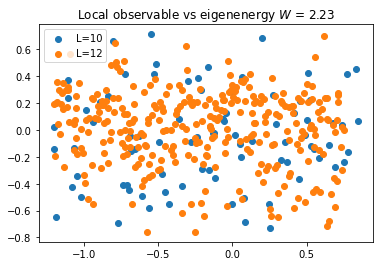

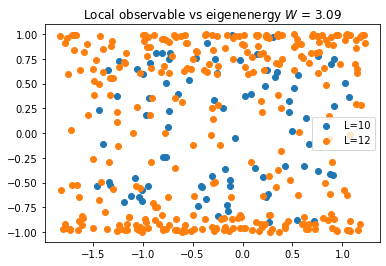

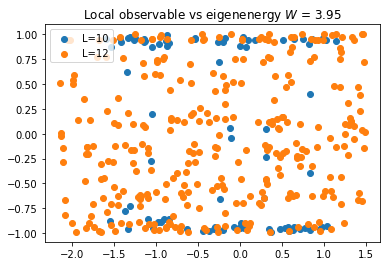

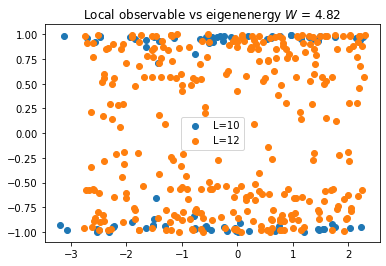

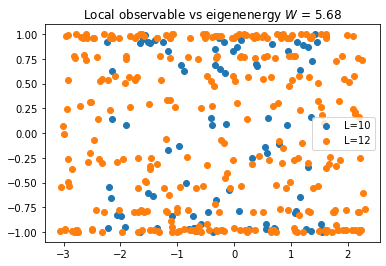

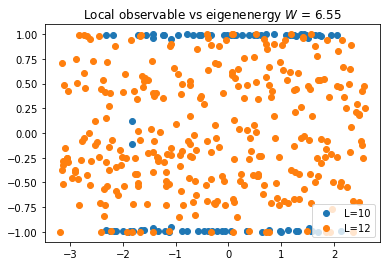

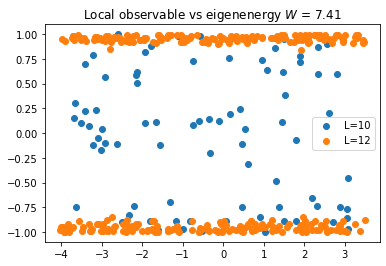

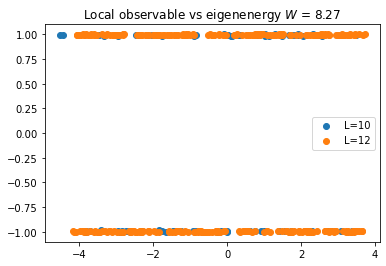

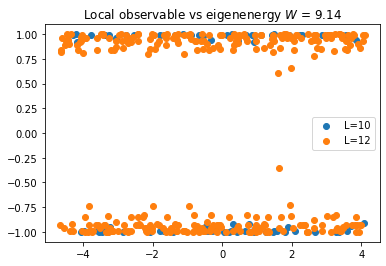

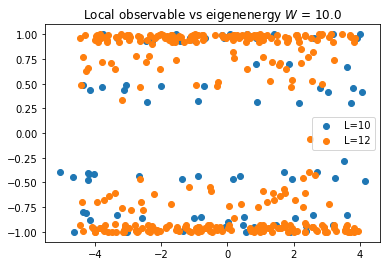

In [ ]:
SZ5 = gen_s0sxsysz(10)[3][4]
SZ6 = gen_s0sxsysz(12)[3][5]
for w_index in range(len(Ws)):
  evals10, evecs10 = L10spectra[10][w_index][1]
  evals12, evecs12 = L12spectra[10][w_index][1]
  full_evec10 = P_totalZ(10) @ evecs10
  full_evec12 = P_totalZ(12) @ evecs12
  expec10 = [full_evec10[:,i].T @ SZ5 @ full_evec10[:,i] for i in range(len(evals10))]
  expec12 = [full_evec12[:,i].T @ SZ6 @ full_evec12[:,i] for i in range(len(evals12))]
  fig, ax = plt.subplots()
  ax.scatter(evals10, expec10, label='L=10')
  ax.scatter(evals12, expec12, label='L=12')
  ax.legend()
  ax.set(title='Local observable vs eigenenergy'+ f' $W$ = {round(Ws[w_index], 2)}')


> We observe that with increasing disorder strength the expectation value $\langle \alpha |\sigma_{L/2}^z|\alpha \rangle$ begins to take on the values -1 and 1 from eigenstate to eigenstate. Although the overall expectation is zero across all eigenstates as we would expect for infinite temperature, we do not observe the ETH in the smooth varying of a local observable with energy (W=0.5 does show this to an extent actually).

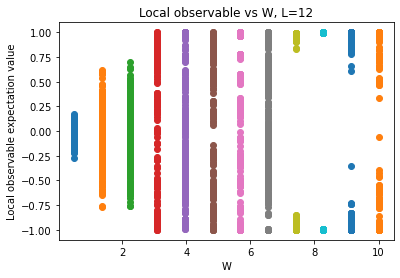

In [ ]:

for w_index in range(len(Ws)):
  evals12, evecs12 = L12spectra[10][w_index][1]
  full_evec12 = P_totalZ(12) @ evecs12
  expec12 = [full_evec12[:,i].T @ SZ6 @ full_evec12[:,i] for i in range(len(evals12))]
  plt.scatter(Ws[w_index]*np.ones(len(evals12)), expec12 )
  plt.xlabel('W')
  plt.ylabel('Local observable expectation value')
  plt.title('Local observable vs W, L=12')

> Here we observe the growth in the spread of the local observable with disorder strength, then separation into +1 and -1 with strong enough disorder, indicating MBL.



(e) [15pts] **Persistence of local memory**. Starting again from a random product state in the $z$ basis with total magnetization $\sum_i \langle \psi_0|\sigma_i^z|\psi_0\rangle = 0$. Plot disorder averaged autocorrelators $\overline{\langle \psi_0 | \sigma_{L/2}^z(t) \sigma_{L/2}^z(0)|\psi_0\rangle}$  as a function of time. Pick a single $L=12$, and plot the curves for different $W$s on the same plot.

What do you observe about the saturation value of  $O(t)$ as a function of $W$? Does it agree with the expected thermal answer (note that random product states on average have are at an energy that would correspond to infinite temperature)? If not, why not?


For time-evolution, it is bettter to express $|\psi_0\rangle$ in the eigenbasis and time-evolve using the eigenvalues and eigenvectors (as opposed to constructing $U(t)$ via matrix exponentiation at each time $t$.




> We would expect for a greater disorder strength that the saturation value of O(t) would be closer to 1, since greater disorder strength corresponds to more localized sites, so we would not expect the expected spin on a given site to flip. For large W we should not see O(t) converge to 0 as we would expect for a thermal state due to the effect of localization. For small W, localization is less pronounced so the saturation value would be closer to 0.

We first generate a random product state with every site spin up or spin down in the z basis and total magnetization zero. This is just one of the columns of the projector of total spin = 0.

In [ ]:
P = P_totalZ(12).toarray()
psi0 = P[:,4]
psi0 = P.T @ psi0
evals12, evecs12 = L12spectra[99][1][1]

def evolve(psi0, t, evals12, evecs12):
  psi = np.zeros(len(psi0),dtype=np.complex128)
  for i in range(len(evals12)):
    psi += np.vdot(evecs[:,i],psi0)*np.exp(-1j*evals12[i]*t)*evecs12[:,i]
  return psi



C:\Users\kapil\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


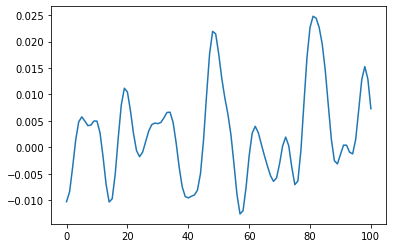

In [ ]:
  ts = np.linspace(0, 100, 101)
  autocorrelators = []
  for t in ts:
    autocorrelators.append(np.vdot(SZ6@P@evolve(psi0, t, evals12, evecs12), SZ6@P@psi0))
  plt.plot(ts, autocorrelators)

C:\Users\kapil\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


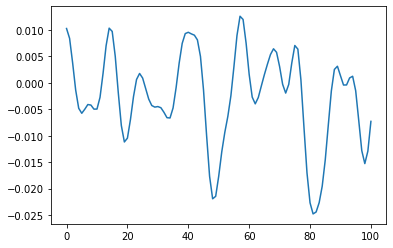

In [ ]:
expa = []
for t in ts:
  expa.append(np.vdot(P@evolve(psi0, t, evals12, evecs12), SZ6@P@psi0))
plt.plot(ts, expa)

C:\Users\kapil\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\kapil\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\kapil\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\kapil\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\kapil\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\kapil\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: C

KeyboardInterrupt: 

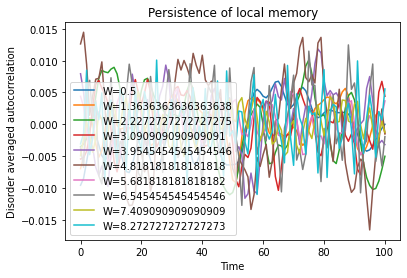

In [ ]:


avg_autocorr = np.zeros((len(Ws), len(ts)))
for w_index in range(len(Ws)):
  avgAC = []
  for t in ts:
    AClist = []
    for i in range(5):
      evals12, evecs12 = L12spectra[i][w_index][1]
      AClist.append(np.vdot(SZ6@P@evolve(psi0, t, evals12, evecs12), SZ6@P@psi0))
    avgAC.append(np.mean(AClist))
  plt.plot(ts, avgAC, label = f'W={Ws[w_index]}')
  plt.xlabel("Time")
  plt.ylabel("Disorder averaged autocorrelation")
  plt.title("Persistence of local memory")
  plt.legend()
  plt.grid()

In [ ]:
H12 = MBL(12, 5).toarray()
evals12, evecs12 = L12spectra[99][1][1]
coeffs = np.random.normal(size=len(evals12))
coeffs /= np.linalg.norm(coeffs)
psi0 = evecs12 @ coeffs
P = P_totalZ(12)

def evolve(psi0, t, evals12, evecs12):
  return evecs12 @ np.diag(np.exp(-1j*evals12*t)) @ psi0

ts = np.linspace(0, 10, 101)

avg_autocorr = np.zeros((len(Ws), len(ts)))
for w_index in range(len(Ws)):
  avgAC = []
  for t in ts:
    AClist = []
    for i in range(5):
      evals12, evecs12 = L12spectra[i][w_index][1]
      AClist.append(np.vdot(SZ6@P@evolve(psi0, t, evals12, evecs12), SZ6@P@psi0))
    avgAC.append(np.mean(AClist))
  plt.plot(ts, avgAC, label = f'W={Ws[w_index]}')
  plt.xlabel("Time")
  plt.ylabel("Disorder averaged autocorrelation")
  plt.title("Persistence of local memory")
  plt.legend()
  plt.grid()


